# Tutorials

In [2]:
import os
import sys
import time
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import pyblip

## 1. Introduction

In many applications, we can tell that a signal of interest exists but cannot perfectly "localize" it. For example, when regressing an outcome $Y$ on highly correlated covariates $(X_1, X_2)$, the data may suggest that *at least* one of $(X_1, X_2)$ influences $Y$, but it may be challenging to tell which of $(X_1, X_2)$ is important. Likewise, in genetic fine-mapping, biologists may have high confidence that a gene influences a disease without knowing precisely which genetic variants cause the disease. Similar problems arise in many settings with spatial or temporal structure, including change-point detection and astronomical point-source detection.

*Bayesian Linear Programming* (BLiP) is a method which jointly detects as many signals as possible while localizing them as precisely as possible. BLiP can wrap on top of nearly any Bayesian model or algorithm, and it will return a set of regions which each contain at least one signal with high confidence. For example, in regression problems, BLiP might return the region $(X_1, X_2)$, which suggests that at least one of $(X_1, X_2)$ is an important variable. BLiP controls the false discovery rate while also making these regions as narrow as possible, meaning that (roughly speaking) it will perfectly localize signals whenever this is possible! See [Spector and Janson (2022)](https://arxiv.org/abs/2203.17208) for more details.

``pyblip`` is an efficient python implementation of BLiP, which is designed so that BLiP can wrap on top of the Bayesian model in only one or two lines of code. Below, we give concrete examples of how to apply ``pyblip`` in three settings: variable selection, change-point detection, and point-source detection.

## 2. Variable selection

### 2.1 Generating synthetic data

Below, we generate synthetic data of highly correlated covariates $X = (X_1, \dots, X_p)$ and a response $Y$.

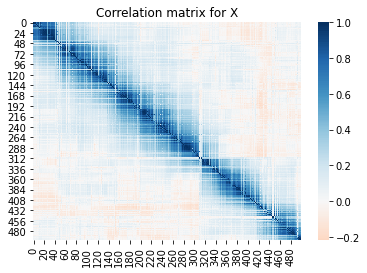

In [2]:
# generate synthetic data with 10 signal variables
np.random.seed(12345)
X, y, beta = pyblip.utilities.generate_regression_data(
    n=300, p=500, k=5, sparsity=0.02, dgp_seed=12345
)
signal_variables = np.where(beta != 0)[0]
# X has strong local correlations
sns.heatmap(np.corrcoef(X.T), cmap='RdBu', center=0)
plt.title('Correlation matrix for X')
plt.show()

### 2.2 Linear Spike-and-Slab model + BLiP

We can apply BLiP in two steps. First, we fit a Bayesian model to $(X, Y)$---in this case, we use a spike-and-slab model for sparse linear regression. Second, we run BLiP directly on top of the posterior samples from the Bayesian model, as shown below.

In [3]:
# Step 1: sample from Gaussian spike-and-slab model
lm = pyblip.linear.LinearSpikeSlab(X=X, y=y)
lm.sample(N=2000, chains=5, burn=200, bsize=3)

In [5]:
# Step 2: Apply BLiP to detect signal variables
t0 = time.time()
detections = pyblip.blip.BLiP(
    samples=lm.betas,
    q=0.1,
    error='fdr',
    verbose=False,
)
print(f"\nBLiP ran in {np.around(time.time() - t0, 2)} seconds.\n")


BLiP ran in 0.96 seconds.



Since the data is synthetic, we can check whether the results from BLiP are accurate.

In [6]:
print(f"The true signal variables are {signal_variables}.")
for x in detections:
    true_detection = len(x.group.intersection(set(signal_variables))) > 0
    if true_detection:
        print(f"BLiP correctly detected a signal variable in {x.group}.")
    else:
        print(f"BLiP incorrectly detected a signal variable in {x.group}.")

The true signal variables are [ 54  68 148 184 272 306 383 409 426 471].
BLiP correctly detected a signal variable in {54}.
BLiP correctly detected a signal variable in {68}.
BLiP correctly detected a signal variable in {184}.
BLiP correctly detected a signal variable in {272}.
BLiP correctly detected a signal variable in {306}.
BLiP correctly detected a signal variable in {383}.
BLiP correctly detected a signal variable in {426}.
BLiP correctly detected a signal variable in {417, 421, 404, 407, 408, 409, 411, 412}.


As we can see, sometimes BLiP will detect individual signal variables, but often this is not possible due to the high correlations among $X$. In the latter case, BLiP outputs larger clusters of variables.

### 2.3 SuSiE + BLiP

BLiP can apply on top of nearly any Bayesian model or algorithm, including variational algorithms. Here, we show how to apply BLiP on top of a SuSiE model [(Wang et al, 2020)](https://www.biorxiv.org/content/10.1101/501114v4). We do this in three steps: Step 1 is to fit SuSiE, Step 2 is to create candidate groups based off of the SuSiE outputs, and Step 3 is to apply BLiP.

In [5]:
# Step 1: Fit SuSiE model
import rpy2
import rpy2.robjects.numpy2ri as numpy2ri
import rpy2.robjects as ro
from rpy2.rinterface_lib.embedded import RRuntimeError
from rpy2.robjects.packages import importr
%load_ext rpy2.ipython

# Import and run susie
susieR = importr('susieR')
R_null = ro.rinterface.NULL
numpy2ri.activate()
susie_obj = susieR.susie(
    X=X, y=y, L=10, coverage=0.9
)
# Extract output
alphas = susie_obj.rx2('alpha')
susie_sets = susie_obj.rx2('sets')[0]
try:
    susie_sets = [
        np.array(s)-1 for s in susie_sets
    ]
except TypeError:
    susie_sets = []

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
# Step 2: create candidate groups based off susie outputs
t0 = time.time()
cand_groups = pyblip.create_groups.susie_groups(
    alphas=alphas,
    X=X,
    q=0.1, # FDR level
)
# Step 3: run BLiP
detections = pyblip.blip.BLiP(
    cand_groups=cand_groups,
    error='fdr',
    q=0.1,
    verbose=False,
)
elapsed = np.around(time.time() - t0, 2)
print(f"\nCreating cand groups and running BLiP took {elapsed} seconds.\n")


Creating cand groups and running BLiP took 0.34 seconds.



We can compare the detections from SuSiE and SuSiE + BLiP. As we can see from the smaller group size, SuSiE + BLiP localizes signals more precisely than SuSiE alone. (All detections are true detections in this case.)

In [7]:
[set(x) for x in susie_sets]

[{68}, {306}, {426}, {184}, {272}, {54}, {382, 383, 384}]

In [8]:
[x.group for x in detections]

[{54}, {68}, {184}, {272}, {306}, {383}, {426}]

As the number of signals increases, SuSiE + BLiP tends to have substantially higher power than SuSiE alone, as discussed in [Spector and Janson (2022)](https://arxiv.org/abs/2203.17208).

### 2.4 Probit spike-and-slab model + BLiP

We can run BLiP on top of nearly any regression model, including various models for binary responses. For example, suppose we only observe a binary indicator $Y^{\star}$ as an outcome. We can apply BLiP directly on top of a sparse probit model in this setting, as shown below.

In [7]:
# Step 1: fit probit model
ystar = y > 0
pm = pyblip.probit.ProbitSpikeSlab(X=X, y=ystar)
pm.sample(N=1000, chains=5, bsize=2)

In [17]:
# Step 2: apply BLiP to posterior samples
t0 = time.time()
detections = pyblip.blip.BLiP(
    samples=pm.betas,
    q=0.1,
    error='fdr',
    verbose=False,
)
print(f"\nBLiP ran in {np.around(time.time() - t0, 2)} seconds.\n")


BLiP ran in 0.58 seconds.
Long-step dual simplex will be used



Once again, we can check that BLiP makes (mostly) correct detections:

In [20]:
print(f"The true signal variables are {signal_variables}.")
for x in detections:
    true_detection = len(x.group.intersection(set(signal_variables))) > 0
    if true_detection:
        print(f"BLiP correctly detected a signal variable in {x.group}.")
    else:
        print(f"BLiP incorrectly detected a signal variable in {x.group}.")

The true signal variables are [ 54  68 148 184 272 306 383 409 426 471].
BLiP correctly detected a signal variable in {68}.
BLiP correctly detected a signal variable in {424, 426}.
BLiP correctly detected a signal variable in {177, 180, 181, 184, 185}.
BLiP correctly detected a signal variable in {263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274}.
BLiP correctly detected a signal variable in {313, 306, 308}.
BLiP incorrectly detected a signal variable in {58, 53}.
BLiP correctly detected a signal variable in {59, 54}.
BLiP correctly detected a signal variable in {398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422}.


### 2.5 Hierarchical priors to ensure error control

BLiP can wrap on top of nearly any Bayesian model, and in practice, it is fairly robust to some degree of model misspecification (see [Spector and Janson (2022)](https://arxiv.org/abs/2203.17208) for simulations and a discussion of this issue). That said, if the underlying model is extremely poorly specified, BLiP will violate FDR control. For example, in the following problem, the prior indicates that $50\%$ of the variables are signal variables, whereas in truth only $4\%$ of the variables are signal variables.

In [4]:
# Sample from an obviously bad spike and slab model
lm_bad = pyblip.linear.LinearSpikeSlab(X=X, y=y, p0=0.5, update_p0=False)
lm_bad.sample(N=2000, chains=5, burn=200, bsize=3)

In [ ]:
# run blip: FDR control fails because the model is very badly mispecified
detections = pyblip.blip.BLiP(
    samples=lm_bad.betas,
    error='fdr',
    q=0.1,
    max_pep=0.25,
    verbose=True
)
sigvars = set(signal_variables)
fdp = np.mean(
    [len(x.group.intersection(sigvars)) == 0 for x in detections]
)
print(f"The false positive rate is {np.around(100*fdp)}% due to the mispecified model!\n")

BLiP problem has 2263 groups in contention, with 500 active features/locations


To avoid this situation, we recommend using **hierarchical priors** on unknown nuisance parameters like the sparsity level in regression problems, with a conservative choice of hyperparameters. The samplers in ``pyblip`` automatically use relatively uninformative hierarchical priors which empirically control the FDR well in a variety of settings. For example, in the previous examples, the prior was quite uninformative, and BLiP still performed quite well.

When using MCMC algorithms, we also recommend **running multiple MCMC chains** with different initializations to protect against convergence issues. As discussed in [Spector and Janson (2022)](https://arxiv.org/abs/2203.17208), even when each individual MCMC chain fails to converge, often using multiple chains will overstate the uncertainty in the location of signals, leading to conservative but valid inference.


## 3. Changepoint detection

Given time series data $(Y_1, \dots, Y_T)$, suppose we are interested in looking for "change-points", or times where the stochastic process changes. Often, we can tell that a process has changed, but we cannot discern exactly when it has changed because each observation $\{Y_t\}$ is noisy. The following synthetic dataset gives one example of this:

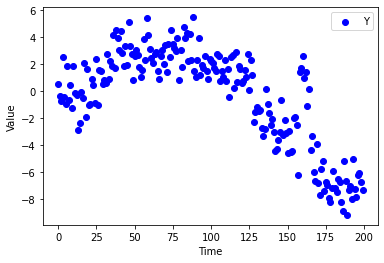

In [47]:
# Changepoint series with 5 data-points
np.random.seed(123)
T = 200
_, Y, beta = pyblip.utilities.generate_changepoint_data(
    T=T, sparsity=0.04, coeff_size=5,
)
mu = np.cumsum(beta) # true mean of Y
plt.scatter(np.arange(T), Y, color='blue', label='Y')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

To detect regions where the true mean of $Y$ has changed, we can call the function ``detect changepoints`` which will fit a spike-and-slab changepoint model and apply BLiP on top of it. This only takes one line!

In [49]:
detections = pyblip.changepoint.detect_changepoints(
    Y=Y, 
    q=0.1, 
    sample_kwargs=dict(N=2000, chains=5, bsize=5), # kwargs for the sampler
    blip_kwargs=dict(max_pep=0.5, verbose=False) # kwargs for BLiP
)

BLiP ran in 11.71.
Long-step dual simplex will be used


Below, we plot these change-points on top of the raw data and the ground truth. Each output from BLiP is a region which contains a change point with high confidence. The detected regions are shaded in the plot: true detections are in green, and false detections are in orange.

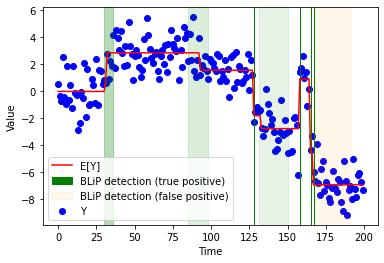

In [66]:
# Plot data-points and ground truth
plt.plot(np.arange(T), mu, color='red', label='E[Y]')
plt.scatter(np.arange(T), Y, color='blue', label='Y')

# Add BLiP detections
changepoints = set(np.where(beta != 0)[0].tolist())
color_counts = dict(orange=0, green=0) # for legend
for j, cs in enumerate(detections):
    cs = cs.group
    if len(changepoints.intersection(cs)) > 0:
        color = 'green'
        cstring = 'true positive'
    else:
        color = 'orange'
        cstring = 'false positive'
    # Decide whether to add a label
    if color_counts[color] == 0:
        color_counts[color] += 1
        label = f'BLiP detection ({cstring})'
    else:
        label = None
        
        
    plt.axvspan(
        min(cs), max(cs), alpha=min(1, 2 / len(cs)),
        color=color,
        label=label
    )

    
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


As we can see, in this example, BLiP does a pretty good job both detecting change-points and quantifying our uncertainty in their locations. The vertical, thin green bars are change-points which have been perfectly localized.

## 4. Point-source detection

Suppose we observe photon counts from a telescope, and we are interested in detecting point-sources (e.g., stars) from the image. Since most images have some blur, we may not be able to perfectly localize each point-source, but BLiP can still help localize them as precisely as possible. Below, we give an example of how to apply BLiP on top of outputs from a pretrained [StarNet model](https://github.com/Runjing-Liu120/DeblendingStarfields). Note that the StarNet model is described in detail in [Liu et. al (2021)](https://arxiv.org/pdf/2102.02409.pdf). 

To start, we load the simulated $20x20$ image data, which was generated using code from [Liu et. al (2021)](https://arxiv.org/pdf/2102.02409.pdf).

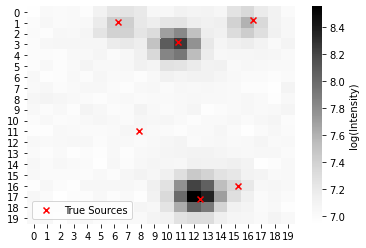

In [3]:
# Load simulated image data
npixels = 20
image = np.loadtxt("data/sim_image.txt").reshape(2, npixels, npixels)
true_locs = np.loadtxt("data/sim_locs.txt").reshape(6, 2)

# plot one of the two bands
def plot_starnet_sim():
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(
        np.log(image[1]), 
        cmap='Greys', ax=ax, 
        cbar_kws=dict(label='log(Intensity)')
    )
    # Plot true locations
    ax.scatter(
        npixels*true_locs[:,1], 
        npixels*true_locs[:,0], 
        color='red', 
        marker='x', 
        label='True Sources'
    )
    return fig, ax

fig, ax = plot_starnet_sim()
ax.legend()
plt.show()

Next, we load the posterior samples from the pretrained StarNet model. See [here](https://github.com/Runjing-Liu120/DeblendingStarfields) or [here](https://github.com/amspector100/DeblendingStarfields) for examples of how to fit pretrained StarNet models.

Note that the posterior samples are an $(N, n_{\mathrm{source}}, d)$-shaped array, where $N$ is the number of posterior samples and $d=2$ is the dimension of the image. If ``post_samples[i, j] = (x, y)``, this means that the $i$th posterior sample has asserted that there is a point-source at location $(x,y)$. Since there may be different numbers of point-sources per iteration, NaNs are ignored. See API reference for more details on the data input format.



In [4]:
# Load posterior samples from StarNet
post_samples = np.loadtxt('data/post_samples.txt').reshape(996, 7, 2)
# Print the location of sources according to the first posterior sample.
# The NaN means there are only six estimated sources.
post_samples[0]

array([[0.07279399, 0.34460315],
       [0.05383444, 0.83722878],
       [0.12657177, 0.60644835],
       [0.54421228, 0.45192835],
       [0.76564646, 0.75837231],
       [0.87883556, 0.64780414],
       [       nan,        nan]])

In [5]:
# In contrast, in the 8th iteration, there were five estimated sources.
post_samples[8]

array([[0.07735128, 0.33859724],
       [0.04566601, 0.82996595],
       [0.19049473, 0.56281787],
       [0.59320527, 0.43181294],
       [0.87796324, 0.6558165 ],
       [       nan,        nan],
       [       nan,        nan]])

Given these posterior samples, applying BLiP is as easy as calling the ``BLiP_cts`` function. Note that ``BLiP_cts`` is useful in problems where the set of possible signal locations is continuous, for example in this problem, where a point-source could take any location in $[0,20]^2$.

In [8]:
# the grid sizes determine the resolutions at which BLiP is applied
grid_sizes = np.unique(np.around(np.logspace(np.log10(4), 4, 50)))
detections = pyblip.blip.BLiP_cts(
    post_samples,
    error='fdr',
    q=0.1, 
    verbose=False,
    rescale=False,
    grid_sizes=grid_sizes
)

We can plot these detections on top of the image to see the detections.

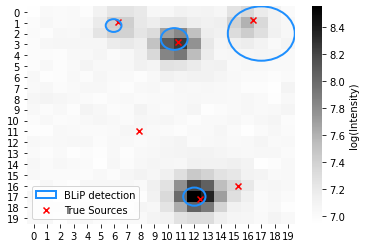

In [9]:
import matplotlib.patches as patches

fig, ax = plot_starnet_sim()
for j, x in enumerate(detections):
    center = npixels * x.data['center']
     # since rescale=False all radii are the same
    radius = npixels * x.data['radii'][0]
    if j == 0:
        label = 'BLiP detection'
    else:
        label = None
    circle = patches.Circle(
        (center[1], center[0]),
        radius, 
        edgecolor=(30/256,144/256,255/256,1),
        facecolor=(1,1,1,0), # make interior transparent
        linewidth=2,
        label=label
    )
    ax.add_patch(circle)
    
ax.legend()
plt.show()

As we can see, BLiP makes four true detections at various resolutions based on the posterior samples.

## 5. Inputs for arbitrary problems

So far, we have reviewed three major problem settings: variable selection, change-point detection, and point-source detection. However, in principle, BLiP can apply to any problem where one is interested in jointly detecting and localizing signals.

In generic problems, there are main types of inputs ``BLiP`` can take.

### 5.1 Posterior samples for discrete problems

``pyblip.blip.BLiP`` can take an $(N,p)$-shaped matrix where nonzero values denote the presence of a signal variable. Here, $N$ is the number of posterior samples and $p$ is the number of locations at which a signal can exist. So if ``samples[i,j] != 0``, this indicates that for in the $i$th posterior sample, the $j$th location contains a signal. We call these problems "discrete" because $p$ is finite.

### 5.2 Posterior samples for continuous problems

In some problems, we may be searching for signals in $\mathbb{R}^d$. In this case, since there are an infinite number of possible locations for signals, we cannot automatically apply ``pyblip.blip.BLiP``.

In this setting, ``pyblip.blip.BLiP_cts`` can posterior samples in a different format as an input. In particular, ``pyblip.blip.BLiP_cts`` assumes the posterior samples are an $(N, n_{\mathrm{source}}, d)$-shaped array, where:
1. $N$ is the number of posterior samples 
2. $d$ is the dimension of the data
3. If ``samples[i, j] = (x1, ..., xd)``, this means that the $i$th posterior sample has asserted that there is a point-source at location $(x_1, \dots, x_d)$. Since there may be different numbers of point-sources per iteration, NaNs are ignored.


### 5.3 Advanced usage: directly specifying candidate groups

A ``CandidateGroup`` object represents a subset of the locations which could potentially contain a signal. For example, in variable selection problems, each ``CandidateGroup`` represents a subset of the covariates. Alternatively, in the following example, each ``CandidateGroup`` represents three circular regions of the globe.

In [82]:
from pyblip.create_groups import CandidateGroup
cand_groups = [
    CandidateGroup(
        group=set([1,2,]), 
        pep=0.01, 
        data=dict(
            latitude=41.0,
            longitude=74.0,
            radius=1,
            name='big_region',
        )
    ),
    CandidateGroup(
        group=set([1,]), 
        pep=0.3, 
        data=dict(
            latitude=41.5,
            longitude=74.0,
            radius=0.01,
            name='sub_region1',
        )
    ),
    CandidateGroup(
        group=set([2,]), 
        pep=0.2, 
        data=dict(
            latitude=40.5,
            longitude=74.0,
            radius=0.01,
            name='sub_region2',
        )
    ),
]

Each ``CandidateGroup`` has three attributes. 

1. The ``pep`` attribute specifies the posterior error probability, or the posterior probability that the candidate group does *not* contain a signal.


2. The ``group`` attribute is a set of positive integers such that two candidate groups overlap if and only if their ``group`` attributes overlap. For example, above, the group attributes suggest that the ``big_region`` overlaps with ``sub_region1`` and ``sub_region2``, but ``sub_region1`` and ``sub_region2`` do not overlap.


3. The ``data`` attribute is a optional dictionary that contains miscallaneous metadata. BLiP largely ignores the ``data`` attribute.

One can directly apply BLiP on top of a list of candidate groups.

In [94]:
detections = pyblip.blip.BLiP(
    cand_groups=cand_groups,
    verbose=False,
    q=0.1,
    error='fdr',
)
print(f"\nBLiP detected the candidate groups named: {[x.data['name'] for x in detections]}")


BLiP detected the candidate groups named: ['big_region']
Long-step dual simplex will be used
